# Inspect the leaf-level interpolation more closely

In the previous notebooks (`2025-06-19_leaf_interpolation.ipynb` and `2025-06-19_quadtree_interpolation.ipynb`), I (Olivia) pieced together the interpolation process to go from a leaf and quadtree, respectively, to a uniform grid. However, the outputs do not quite match Owen's reference code. So, in this notebook I will be going through the choices of uniform grid/orientation etc. more carefully on a leaf level.

Note: the y axis is flipped for the Chebyshev nodes at the leaf-level, but not for the uniform nodes.


Also, try to figure out the reverse direction: uniform-to-chebyshev, and possibly try to accelerate the lagrangian interpolation matrix code (since it has a ton of for loops that I think are not vectorized?)

In [1]:
import os
import jax
import jax.numpy as jnp
from scipy.io import savemat
import matplotlib.pyplot as plt

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)

2025-06-20 16:10:00.708:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-20 16:10:00.711:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-20 16:10:00.713:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-20 16:10:00.714:jaxhps: DEBUG - Creating converter from 5 to 7


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)
from src.jaxhps import (
    Domain as MyDomain,
    DiscretizationNode2D as MyDiscretizationNode2D
)
from jaxhps._grid_creation_2D import (
    rearrange_indices_ext_int as rearrange_indices_ext_int_2D,
)
from jaxhps.quadrature import barycentric_lagrange_interpolation_matrix_2D, chebyshev_points
from jaxhps._interpolation_methods import interp_to_hps_2D
INTERP_BATCH_SIZE = 20

### Basic setup

In [3]:
q_fn_handle = lambda x: q_gaussian_bumps(0.6 * x)
domain_bounds = jnp.array([-1., 1., -1., 1.])

In [4]:
leaf_root = DiscretizationNode2D(-1., 1., -1., 1.)

n_per_leaf = 24
leaf_p = 16
leaf_domain = Domain(p=leaf_p, q=leaf_p-2, root=leaf_root, L=0)

## Interpolation setup

In [5]:
# Interpolation setup
leaf_cheb_x = chebyshev_points(leaf_p)
leaf_cheb_y = chebyshev_points(leaf_p)[::-1]

cell_offset = 0
leaf_unif_x = cell_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
leaf_unif_y = cell_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False) # [::-1]

leaf_cheb_xy = jnp.array(jnp.meshgrid(leaf_cheb_x, leaf_cheb_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
leaf_unif_xy = jnp.array(jnp.meshgrid(leaf_unif_x, leaf_unif_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
q_leaf_unif = q_fn_handle(leaf_unif_xy)

# Maybe this shouldn't be jitted since I only plan to call it once?
tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y,
    to_pts_x=leaf_unif_x,
    to_pts_y=leaf_unif_y,
)
rearrange_idcs = rearrange_indices_ext_int_2D(leaf_p)
interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif[:, rearrange_idcs]

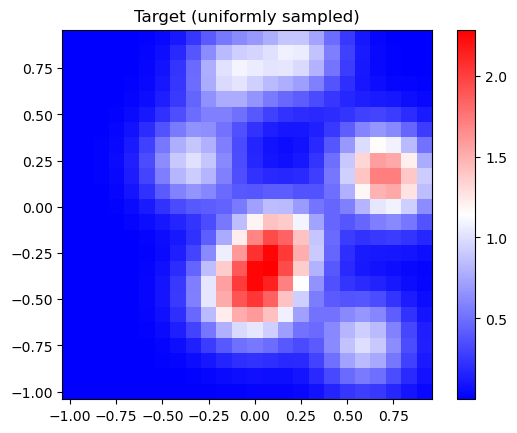

In [8]:
plt.title(f"Target (uniformly sampled)")
plt.pcolormesh(
    leaf_unif_x,
    leaf_unif_y,
    q_leaf_unif.reshape(n_per_leaf, n_per_leaf).T,
    cmap="bwr",
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Reference interpolation

In [9]:
ref_leaf_cheb_pts = leaf_domain.interior_points.reshape(-1, 2)
ref_q_leaf_cheb   = q_fn_handle(ref_leaf_cheb_pts)

In [10]:
cheb_order_matches = jnp.allclose(ref_leaf_cheb_pts, leaf_cheb_xy[rearrange_idcs]).item()
print(f"Rearranged Chebyshev order matches (ref vs. mine): {cheb_order_matches}")

Rearranged Chebyshev order matches (ref vs. mine): True


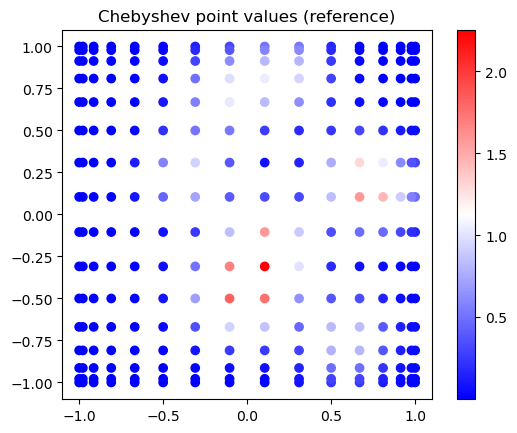

In [11]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (reference)")
plt.scatter(*ref_leaf_cheb_pts[vis_slice].T, c=jnp.real(ref_q_leaf_cheb), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [12]:
%time
xvals_reg = jnp.linspace(-1., 1., n_per_leaf, endpoint=False)
yvals_reg = jnp.linspace(-1., 1., n_per_leaf, endpoint=False)

ref_leaf_unif, ref_target_pts = leaf_domain.interp_from_interior_points(
    samples=ref_q_leaf_cheb.reshape(1,-1),
    eval_points_x=xvals_reg,
    eval_points_y=yvals_reg,
)

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 8.82 μs


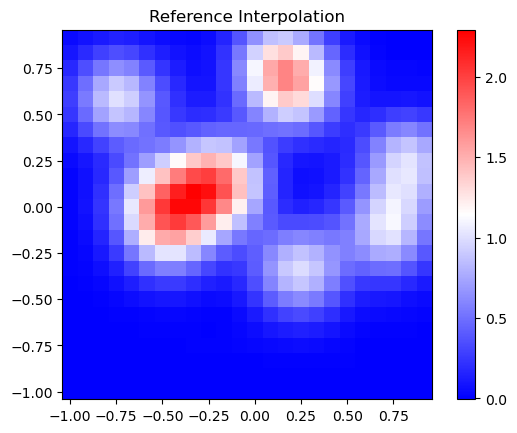

In [13]:
plt.title(f"Reference Interpolation")
plt.pcolormesh(
    leaf_unif_x,
    leaf_unif_y,
    ref_leaf_unif.T,
    cmap="bwr"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Try to use the original code for interpolation

In [14]:
q_leaf_cheb  = q_fn_handle(jnp.take(leaf_cheb_xy, rearrange_idcs, axis=0))
my_leaf_unif = (interp_leaf_cheb_to_unif @ q_leaf_cheb).reshape(n_per_leaf, n_per_leaf).T

In [15]:
# vis_slice = jnp.s_[:]
# plt.title(f"My Unif Interpolation (scatterplot)")
# plt.scatter(*leaf_unif_xy[vis_slice].T, c=jnp.real(my_leaf_unif.flatten())[vis_slice], cmap="bwr")
# plt.gca().set_aspect(1)
# plt.colorbar()
# plt.show()

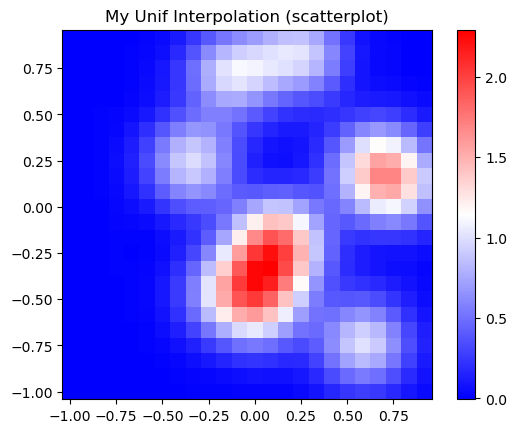

In [16]:
plt.title(f"My Unif Interpolation (scatterplot)")
plt.pcolormesh(
    leaf_unif_x,
    leaf_unif_y,
    my_leaf_unif,
    cmap="bwr",
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Reverse direction

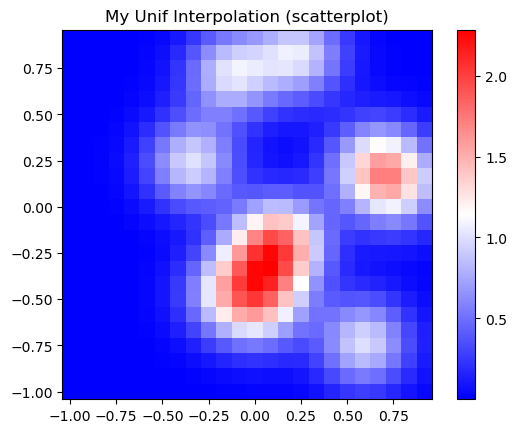

In [17]:
plt.title(f"My Unif Interpolation (scatterplot)")
plt.pcolormesh(
    leaf_unif_x,
    leaf_unif_y,
    q_leaf_unif.reshape(n_per_leaf, n_per_leaf).T,
    cmap="bwr",
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [19]:
# Throws an error and I'm not quite sure why.. probably something with jax.vmap

# ref_leaf_cheb = interp_to_hps_2D(
#     domain_bounds,
#     # jnp.array([-1., 1., -1., 1.]),
#     q_leaf_unif.reshape(n_per_leaf, n_per_leaf),
#     leaf_p,
#     leaf_unif_x,
#     leaf_unif_y,
# )

In [20]:
tmp_interp_leaf_unif_to_cheb = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_unif_x,
    from_pts_y=leaf_unif_y,
    to_pts_x=leaf_cheb_x,
    to_pts_y=leaf_cheb_y,
)
# rearrange_idcs_2 = jnp.argsort(rearrange_indices_ext_int_2D(leaf_p))
rearrange_idcs_2 = rearrange_indices_ext_int_2D(leaf_p)
interp_leaf_unif_to_cheb = tmp_interp_leaf_unif_to_cheb[rearrange_idcs_2, :]

my_leaf_cheb_xy = jnp.take(leaf_cheb_xy, rearrange_idcs_2, axis=0)
my_leaf_cheb = (interp_leaf_unif_to_cheb @ q_leaf_unif.flatten()).reshape(leaf_p, leaf_p) # .T

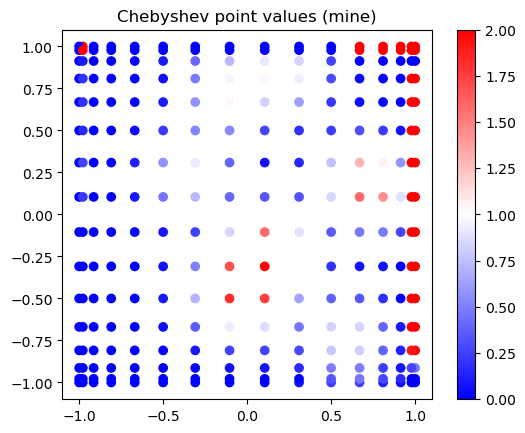

In [21]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (mine)")
plt.scatter(*my_leaf_cheb_xy[vis_slice].T, c=jnp.real(jnp.clip(my_leaf_cheb, 0, 2)), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

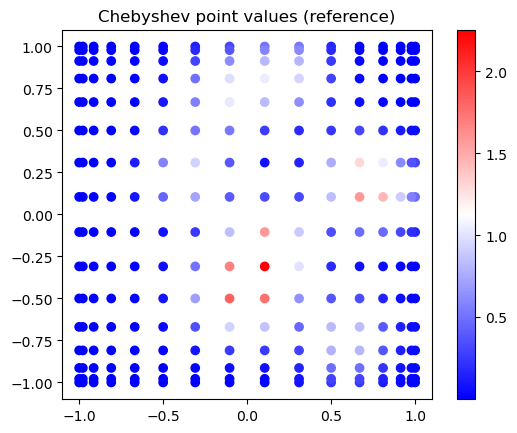

In [22]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (reference)")
plt.scatter(*ref_leaf_cheb_pts[vis_slice].T, c=jnp.real(ref_q_leaf_cheb), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [35]:
EPS = jnp.finfo(jnp.float64).eps

# @jax.jit
def notebook_barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x: jax.Array,
    from_pts_y: jax.Array,
    to_pts_x: jax.Array,
    to_pts_y: jax.Array,
) -> jax.Array:
    """
    Notebook version of barycentric_lagrange_interpolation_matrix_2D from src.jaxhps.quadrature._interpolation_methods
    Goals:
        1) avoid exploding the values
        2) ideally parallelize the tasks a little better
    
    2D Barycentric Lagrange interpolation matrix. A generalization of [1]_,
    modeled after the MATLAB code snippet [2]_.

    The grid of source points is specified by ``from_pts_x`` and ``from_pts_y``. The
    resulting matrix has columns ordered to map from samples on this list of points:

    .. code:: python

       source_X, source_Y = jnp.meshgrid(from_pts_x, from_pts_y, indexing="ij")
       source_pts = jnp.stack((source_X.flatten(), source_Y.flatten()), axis=-1)

    Similarly, the rows are ordered to assume a grid of target points specified by:

    .. code:: python

       target_X, target_Y = jnp.meshgrid(to_pts_x, to_pts_y, indexing="ij")
       target_pts = jnp.stack((target_X.flatten(), target_Y.flatten()), axis=-1)


    Args:
        from_pts_x (jax.Array): Has shape (n_x,)
        from_pts_y (jax.Array): Has shape (n_y,)
        to_pts_x (jax.Array): Has shape (p_x,)
        to_pts_y (jax.Array): Has shape (p_y,)

    Returns:
        jax.Array: Has shape (p_x * p_y, n_x * n_y)
    """
    n_x = from_pts_x.shape[0]
    p_x = to_pts_x.shape[0]
    n_y = from_pts_y.shape[0]
    p_y = to_pts_y.shape[0]
    # print("barycentric_lagrange_2d_interpolation_matrix: n, p", n, p)

    # Compute the inverses of the barycentric weights for x and y dimensions.
    # w_x[j] = \prod_{k != j} (from_pts_x[j] - from_pts_x[k])
    w_x = jnp.ones(n_x, dtype=jnp.float64)
    w_y = jnp.ones(n_y, dtype=jnp.float64)

    # Original version
    # for j in range(n_x):
    #     for k in range(n_x):
    #         if j != k:
    #             w_x = w_x.at[j].mul(from_pts_x[j] - from_pts_x[k])
    # for j in range(n_y):
    #     for k in range(n_y):
    #         if j != k:
    #             w_y = w_y.at[j].mul(from_pts_y[j] - from_pts_y[k])

    # (2025-06-20, OOT) Vectorized version
    # Seems to be a bit faster than the original
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    from_x_ii = jnp.arange(n_x)
    tmp_from_xdist = from_pts_x[:, jnp.newaxis] - from_pts_x[jnp.newaxis, :]
    tmp_from_xdist = tmp_from_xdist.at[from_x_ii,from_x_ii].set(1.)
    w_x = jnp.prod(tmp_from_xdist, axis=0)
    from_y_ii = jnp.arange(n_y)
    tmp_from_ydist = from_pts_y[:, jnp.newaxis] - from_pts_y[jnp.newaxis, :]
    tmp_from_ydist = tmp_from_ydist.at[from_y_ii, from_y_ii].set(1.)
    w_y = jnp.prod(tmp_from_ydist, axis=0)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Compute matrix of distances between x and y points.
    xdist = to_pts_x[None, :] - from_pts_x[:, None]
    ydist = to_pts_y[None, :] - from_pts_y[:, None]

    # Replace exact 0's with EPS. This is to avoid division by zero.
    # This is a bit of a hack and the proper way to do this is identifying which
    # rows/cols of the matrix need to be amended using 1D interpolation maps.
    # But this is a good quick fix.
    xdist = jnp.where(xdist == 0, EPS, xdist)
    ydist = jnp.where(ydist == 0, EPS, ydist)

    # Compute the normalization factors for x and y dimensions.
    norm_factors_x = jnp.sum(1 / (w_x[:, None] * (xdist)), axis=0)
    norm_factors_y = jnp.sum(1 / (w_y[:, None] * (ydist)), axis=0)

    # Compute the matrix, iterating over the y_pts first.
    i, j, k, l = jnp.indices((p_x, p_y, n_x, n_y))
    matrix = 1 / (
        xdist[k, i]
        * ydist[l, j]
        * w_x[k]
        * w_y[l]
        * norm_factors_x[i]
        * norm_factors_y[j]
    )

    matrix = matrix.reshape(p_x * p_y, n_x * n_y)

    return matrix

In [39]:
%timeit barycentric_lagrange_interpolation_matrix_2D(\
    from_pts_x=leaf_cheb_x,\
    from_pts_y=leaf_cheb_y,\
    to_pts_x=leaf_unif_x,\
    to_pts_y=leaf_unif_y,\
)

436 μs ± 138 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [38]:
%timeit notebook_barycentric_lagrange_interpolation_matrix_2D(\
    from_pts_x=leaf_cheb_x,\
    from_pts_y=leaf_cheb_y,\
    to_pts_x=leaf_unif_x,\
    to_pts_y=leaf_unif_y,\
)

80.7 μs ± 9.5 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
orig_interp_leaf_cheb_to_unif = jnp.copy(interp_leaf_cheb_to_unif)
alt_interp_leaf_cheb_to_unif = notebook_barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y,
    to_pts_x=leaf_unif_x,
    to_pts_y=leaf_unif_y,
)[:, rearrange_idcs_2]

is_close = jnp.allclose(orig_interp_leaf_cheb_to_unif, alt_interp_leaf_cheb_to_unif)
is_equal = jnp.all(orig_interp_leaf_cheb_to_unif == alt_interp_leaf_cheb_to_unif)

print(f"Alternate matrix is close? {is_close}")
print(f"Alternate matrix is equal? {is_equal}")

Alternate matrix is close? True
Alternate matrix is equal? True
